# Spectral Power Distribution + Cone Response Demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

### Defining our trichromatic cone response functions

In [2]:
# L cone
mu_l = 565   
sigma_l = 20 

# M cone
mu_m = 540     
sigma_m = 20 

# S cone
mu_s = 445     
sigma_s = 20  

wavelengths = np.linspace(390, 700, 1000)

# Parametrizing each cone repsonse as a gaussian
l = (1 / (np.sqrt(2 * np.pi * sigma_l**2))) * np.exp(- (wavelengths - mu_l)**2 / (2 * sigma_l**2))
m =  (1 / (np.sqrt(2 * np.pi * sigma_m**2))) * np.exp(- (wavelengths - mu_m)**2 / (2 * sigma_m**2))
s =  (1 / (np.sqrt(2 * np.pi * sigma_s**2))) * np.exp(- (wavelengths - mu_s)**2 / (2 * sigma_s**2))

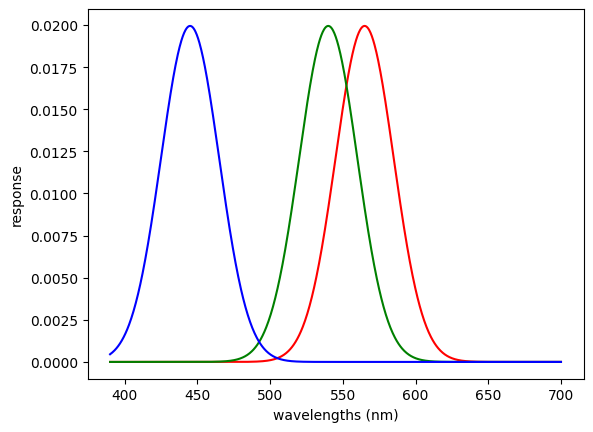

In [3]:
plt.plot(wavelengths, l, color="r")
plt.plot(wavelengths, m, color="g")
plt.plot(wavelengths, s, color="b")
plt.xlabel("wavelengths (nm)")
plt.ylabel("response")
plt.show()

### Creating an SPD of the blue sky

In [4]:
# creating an spd of the blue sky
def createspd(arr, finalsize=1000, smoothfactor = 30):
    """ given a discrete numpy array of shape (8,), 
        make an SPD with finalsize values"""
    n_interp = finalsize // (arr.shape[0] - 1)
    spd_interp = np.concatenate([
        np.linspace(arr[i], arr[i+1], n_interp + 2)[:-1]
        for i in range(len(arr) - 1)
    ])
    spd_interp = spd_interp[:finalsize]
    spd = gaussian_filter1d(spd_interp, sigma=smoothfactor)
    return spd
    
arr = np.array([0.2, 1.0, 1.0, 0.8, 0.9, 0.7, 0.65, 0.5])
bluesky_spd = createspd(arr)

Text(0, 0.5, 'intensity')

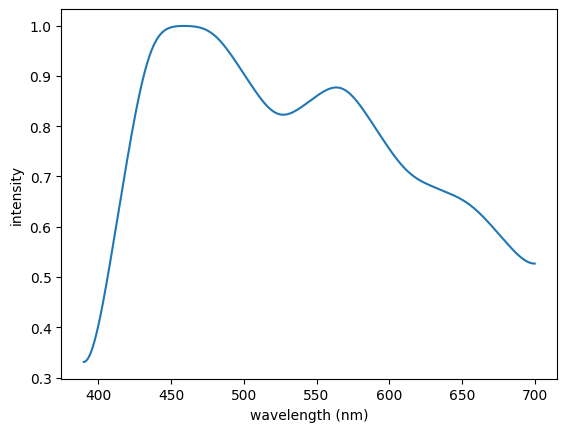

In [5]:
plt.plot(wavelengths, bluesky_spd)
plt.xlabel("wavelength (nm)")
plt.ylabel("intensity")

### Determining the color of the sky as a trichromat

In [6]:
def lms_spd_response(spd, lcone=l, mcone=m, scone=s):
    l_cone_response = np.dot(lcone, spd)
    m_cone_response = np.dot(mcone, spd)
    s_cone_response = np.dot(scone, spd)

    lms_response = np.array([
        l_cone_response,
        m_cone_response,
        s_cone_response
    ])

    lms_response = lms_response / np.linalg.norm(lms_response)
    return lms_response

In [7]:
lms_sky =  lms_spd_response(bluesky_spd)

#### Matrices transforming from LMS cone response space to some displayable RGB color

In [ ]:
def lms_to_rgb(lms):
    """ please note that any rgb gamut is limited 
    compared to  the spectrum of colors that 
    a typical human trichromat can see. 
    """
    raw = xyz_to_rgb(lms_to_xyz(lms))
    return raw

def xyz_to_rgb(xyz):
    """Bradford's spectrally sharpened matrix M_BFD"""
    return np.array([
        [0.8951, 0.3664, -0.1614],
        [-0.7502, 1.7135, 0.0367],
        [0.0389, -0.0685, 1.0296]
    ]) @ xyz

def lms_to_xyz(lms):
    """stockman sharpe 2000"""
    return np.array([
        [1.94735469, -1.41445123, 0.36476327],
        [0.68990272,  0.34832189, 0.00000000],
        [0.00000000,  0.00000000, 1.93485343]
    ]) @ lms

def linear_to_srgb(color):
    """Apply sRGB gamma correction to a linear RGB color."""
    color = np.clip(color, 0, 1)  # Ensure values are in range
    a = 0.055
    threshold = 0.0031308
    srgb = np.where(
        color <= threshold,
        12.92 * color,
        (1 + a) * np.power(color, 1 / 2.4) - a
    )
    return srgb

In [9]:
color = lms_to_rgb(lms_sky)
gammacolor = linear_to_srgb(color)
swatch_gamma = np.ones((100, 100, 3)) * gammacolor
swatch_nogamma = np.ones((100, 100, 3)) * color


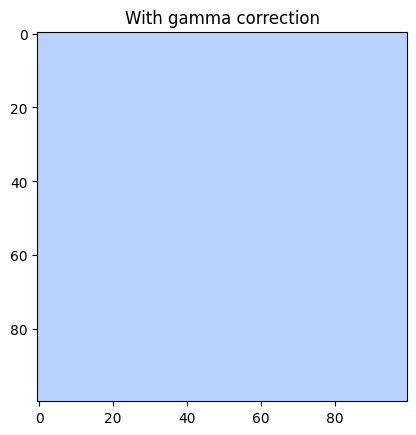

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.4855719722767287..1.1908010825775788].


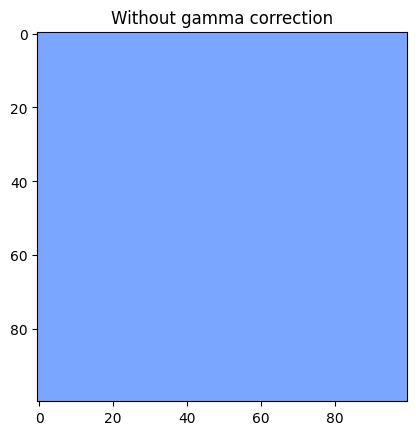

In [10]:
plt.imshow(swatch_gamma)
plt.title("With gamma correction")
plt.show()
plt.title("Without gamma correction")
plt.imshow(swatch_nogamma)
plt.show()

## Colors under Different Lighting Conditions

#### Define two different objects with their own reflectance spectrum

In [11]:
object1_reflectance = np.array([0.2, 0.3, 0.4, 0.4, 0.5, 0.2, 0.1, 0.5])
object1_reflectance = createspd(object1_reflectance)

object2_reflectance = np.array([0.1, 0.3, 0.2, 0.2, 0.2, 0.9, 0.9, 0.5])
object2_reflectance = createspd(object2_reflectance)

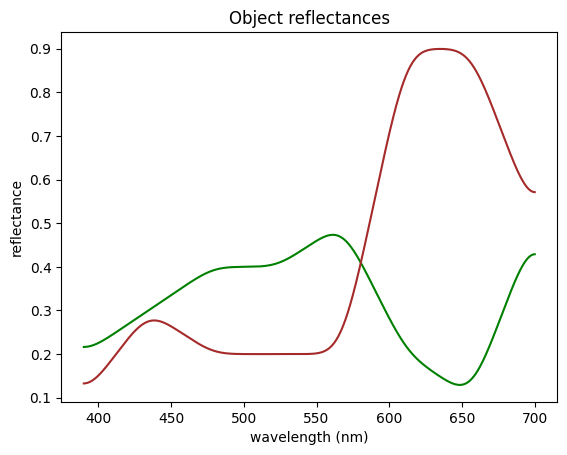

In [12]:
plt.figure()
plt.plot(wavelengths, object1_reflectance, color="green")
plt.plot(wavelengths, object2_reflectance, color="brown")
plt.xlabel("wavelength (nm)")
plt.ylabel("reflectance")
plt.title("Object reflectances")
plt.show()

### Colors of these two objects under the sun

In [13]:
from scipy.constants import h, c, k

In [14]:
# imported constants are in the metric system
c_nm  = c * 1e9 # c in nm / s
freqs = c_nm  / wavelengths # Hz
T_sun = 6000 # kelvin

In [ ]:
sun_spd = (2 * h * freqs ** 3 / c**2) / (np.e ** (h * freqs / (k * T_sun)) - 1) # plancks function approximate sun lighting in visible wavelengths
sun_spd = sun_spd / np.mean(sun_spd)

Text(0.5, 1.0, 'Blackbody spectrum (SPD)of the sun')

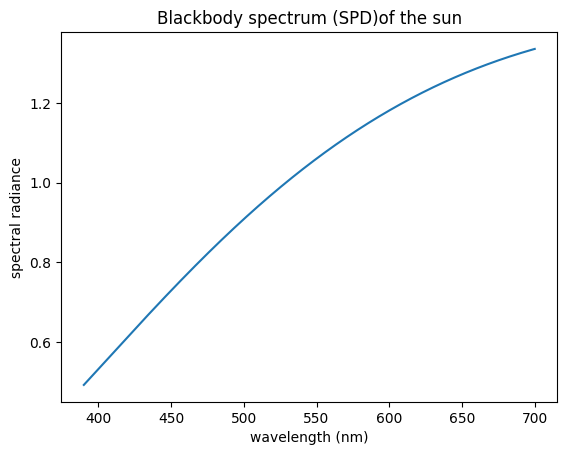

In [16]:
plt.plot(wavelengths, sun_spd)
plt.xlabel("wavelength (nm)")
plt.ylabel("spectral radiance")
plt.title("Blackbody spectrum (SPD)of the sun")

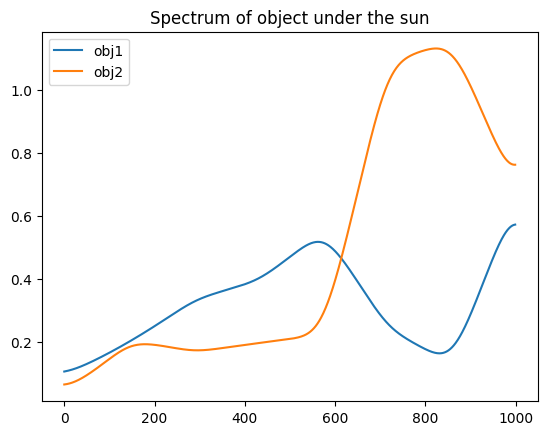

In [17]:
object1_spd = object1_reflectance * sun_spd
object2_spd = object2_reflectance * sun_spd
plt.plot(object1_spd, label="obj1")
plt.plot(object2_spd, label="obj2")
plt.title("Spectrum of object under the sun")
plt.legend()

In [18]:
lms_obj1 = lms_spd_response(object1_spd)
lms_obj2 = lms_spd_response(object2_spd)


In [19]:
color_obj1 = lms_to_rgb(lms_obj1)
swatch_obj1 = np.ones((100, 100, 3)) * color_obj1

color_obj2 = lms_to_rgb(lms_obj2)
swatch_obj2 = np.ones((100, 100, 3)) * color_obj2

#### Object reflectances underneath a sun's lighting as perceived by a trichromat

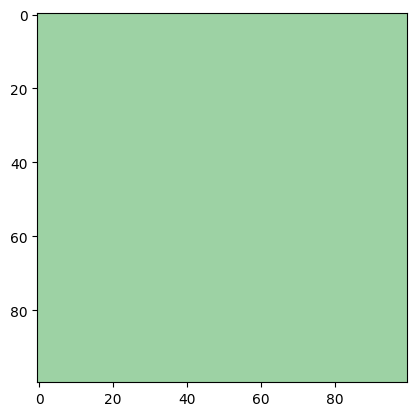

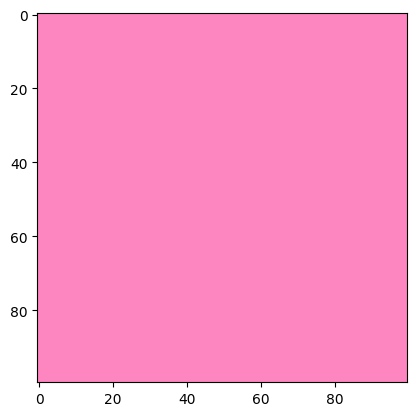

In [20]:
plt.imshow(swatch_obj1)
plt.show()

plt.imshow(swatch_obj2)
plt.show()

### LED

In [21]:
led_spd = np.array([0.05, 0.5, 0.1, 0.6, 0.7, 0.9, 0.6, 0.05])
led_spd = createspd(led_spd)

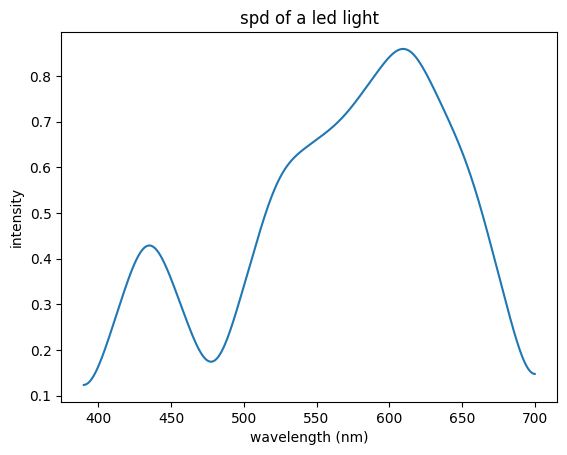

In [22]:
plt.plot(wavelengths, led_spd)
plt.xlabel("wavelength (nm)")
plt.ylabel("intensity")
plt.title("spd of a led light")
plt.show()

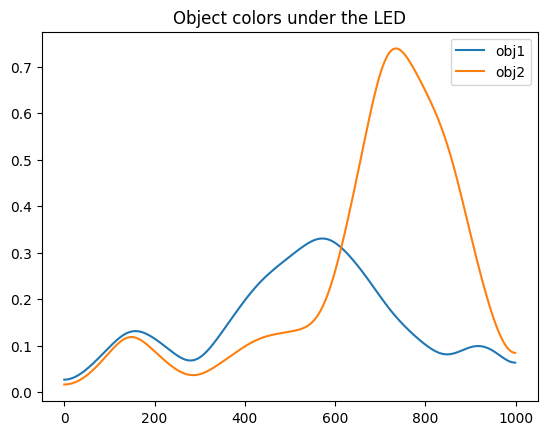

In [23]:
object1_spd_led = object1_reflectance * led_spd
object2_spd_led = object2_reflectance * led_spd
plt.plot(object1_spd_led, label="obj1")
plt.plot(object2_spd_led, label="obj2")
plt.title("Object colors under the LED")
plt.legend()

In [24]:
lms_obj1_led = lms_spd_response(object1_spd_led)
lms_obj2_led = lms_spd_response(object2_spd_led)

In [27]:
color_obj1_led = lms_to_rgb(lms_obj1_led)
swatch_obj1_led = np.ones((100, 100, 3)) * color_obj1_led

color_obj2_led = lms_to_rgb(lms_obj2_led)
swatch_obj2_led = np.ones((100, 100, 3)) * color_obj2_led

#### Object reflectances underneath a LED's lighting as perceived by a trichromat

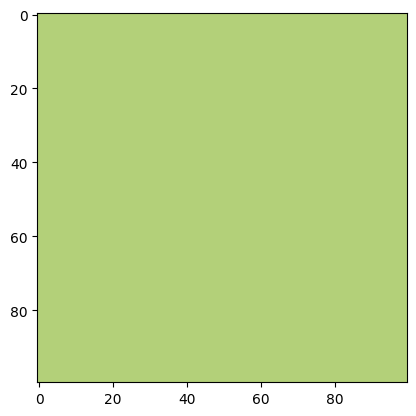

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5060611893245958..1.1055584196297965].


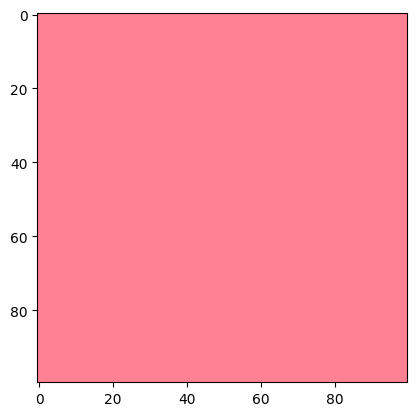

In [29]:
plt.imshow(swatch_obj1_led)
plt.show()

plt.imshow(swatch_obj2_led)
plt.show()